In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import os
from datetime import datetime

from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess

In [2]:

# Define model workspace

myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
temp_dir = mkdtemp(prefix='_T{}_{}_'.format(myt,name))
os.makedirs(Path(temp_dir) / '_output')

#model_ws = "./modflow_model_2"
model_ws = temp_dir

def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(model_ws)

In [21]:
# Create a MODFLOW model instance
model = flopy.seawat.Seawat(modelname="example_model", model_ws=model_ws, exe_name="swtv4")


In [22]:
# Define model dimensions
nlay = 60
nrow = 220
ncol = 220
delr = 10.0  # Cell width along rows (extend 2200 / 220)
delc = 10.0  # Cell width along columns (extend 2200 / 220)

# Define top elevation
top_elev = 190.0

# Define layer thickness (uniform thickness)
layer_thickness = 30.0 / nlay

perlen = 30
nper = 3
nstp = np.repeat(1,nper)
steady = np.append(np.array([True]),np.repeat(False,nper-1))
steady=[False,False,True]

# Create DIS package
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc,top=top_elev, 
                               botm=[top_elev - (i * layer_thickness) for i in range(1, nlay + 1)],
                               nper = nper,
                               perlen = perlen,
                               nstp = nstp,
                               steady = steady)



In [23]:
import numpy as np
from shapely.geometry import Polygon, Point

def change_array_within_polygon(array, row_coords, col_coords, value):

    # Create a polygon object from the row and column coordinates
    polygon = Polygon(zip(col_coords, row_coords))

    # Create a boolean mask indicating which points fall within the polygon
    mask = np.zeros_like(array, dtype=bool)
    for row in range(array.shape[0]):
        for col in range(array.shape[1]):
            point = Point(col, row)
            if polygon.contains(point) or polygon.intersects(point):
                mask[row, col] = True

    # Set the values of the array that fall within the polygon to the new value
    array[mask] = value

    return array


# Example usage
 # Create a 50x190 numpy array filled with zeros

# Define the row and column coordinates of the polygon
row_coords = [0, 20, 20,0]
col_coords = [0, 0, 20,20]



In [3]:
from scipy.interpolate import make_interp_spline

x = np.array([0, 100, 340, 600, 750, 850, 1100, 1350, 1450, 1530, 1650, 1750, 1850, 2050, 2200])
y_topo = np.array([190,190,187,184,184,184,183,182,179,175.5,175,173.8,173.5,172,171]) #topo
y_clay = np.array([185,184,180,175,174,174,173,170,169,168.5,167.5,166.8,166.5,165,164]) #clay



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_topo)
x_smooth_topo = np.linspace(x.min(), x.max(), 30)
y_smooth_topo = spl(x_smooth_topo)

col_coords = (x_smooth_topo/delr).round(0)
col_coords_topo = list(col_coords) +[nrow,0]

row_coords = ((top_elev - y_smooth_topo)/layer_thickness).round(0)
row_coords_topo  =  list(row_coords) +[0,0]



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_clay)
x_smooth = np.linspace(x.min(), x.max(), 30)
y_smooth = spl(x_smooth)

col_coords = (x_smooth/delr).round(0)
col_coords_clay = list(col_coords) +[nrow,0]
row_coords = ((top_elev - y_smooth)/layer_thickness).round(0)
row_coords_clay  =  list(row_coords) +[nlay,nlay]



NameError: name 'delr' is not defined

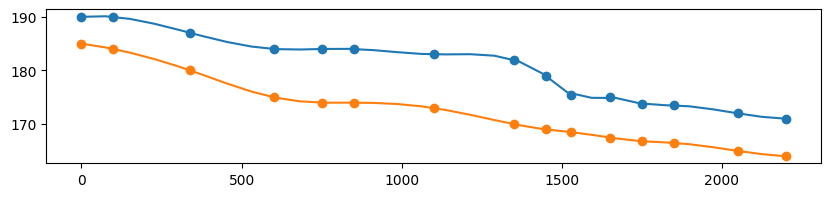

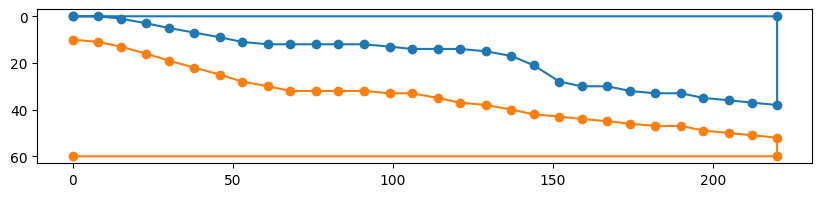

In [26]:

plt.scatter(x, y_topo)
plt.plot(x_smooth_topo, y_smooth_topo)

# Plot the original data and the smooth curve
plt.scatter(x, y_clay)
plt.plot(x_smooth, y_smooth)


plt.gcf().set_size_inches(10,2)
# Show the plot
plt.show()


plt.plot(col_coords_topo,row_coords_topo)
plt.scatter(col_coords_topo,row_coords_topo)

plt.plot(col_coords_clay,row_coords_clay)
plt.scatter(col_coords_clay,row_coords_clay)


plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10,2)

head 185.5
186.0
186.5
187.0
187.5


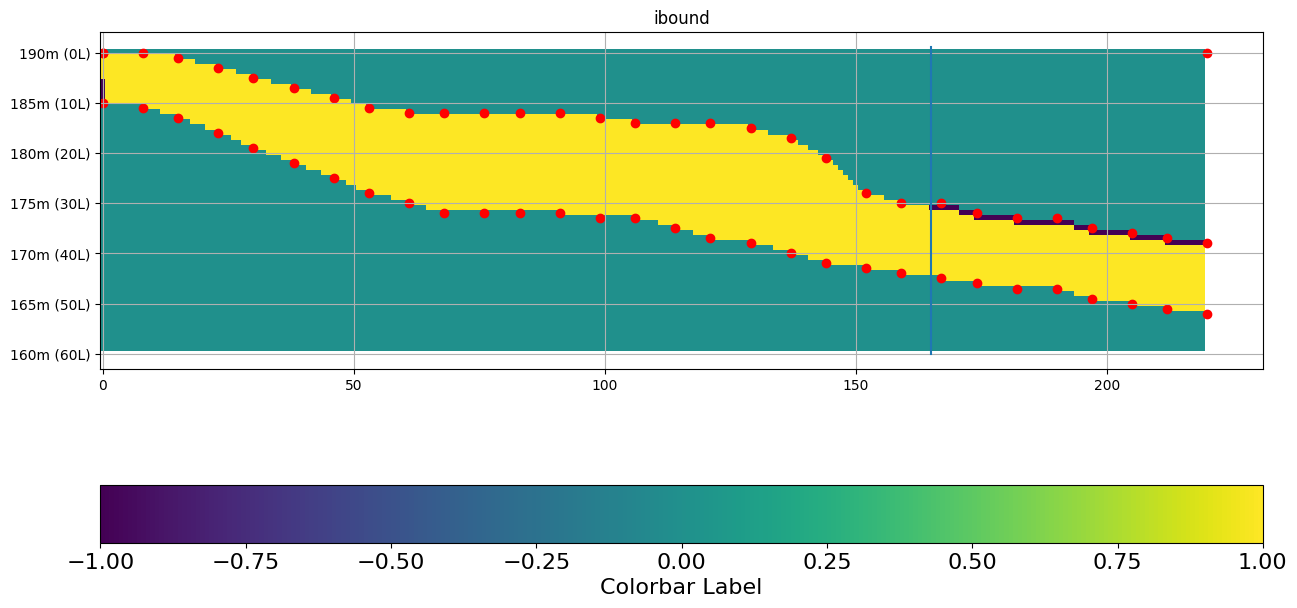

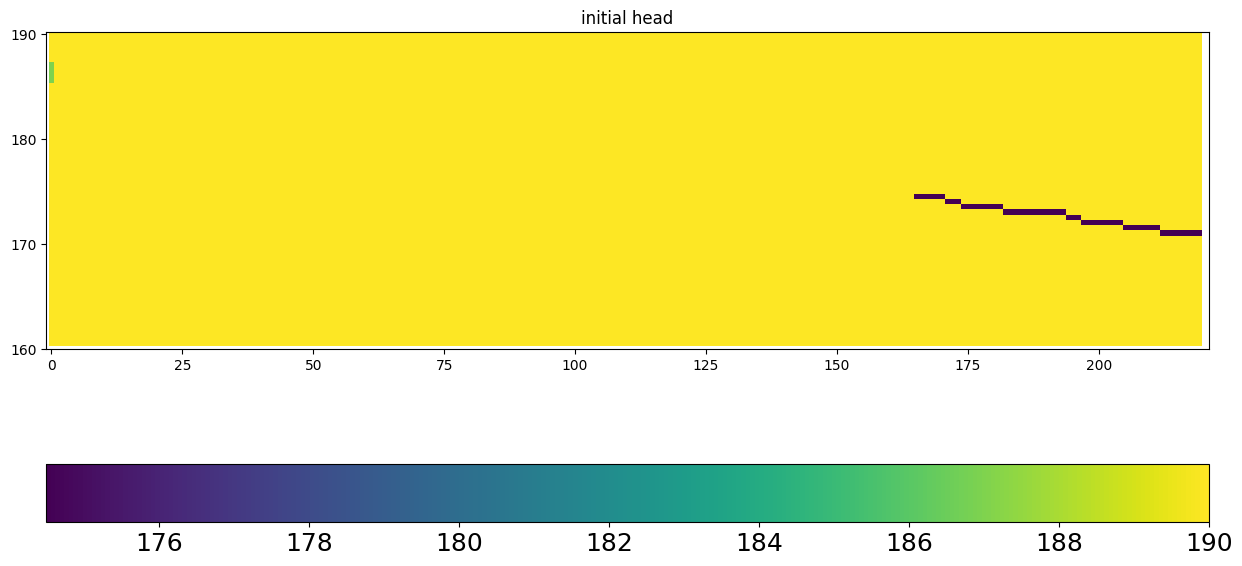

In [99]:

# Define ibound and initial conditionsa
ibound = np.ones((nlay, nrow, ncol), dtype=int)
initial_head = np.full((nlay, nrow, ncol), 190.0, dtype=float)

# Set constant head boundary conditions for the first and last rows


array = change_array_within_polygon(ibound, row_coords_topo, col_coords_topo, 0)
plt.scatter(col_coords_topo,row_coords_topo,c='r')


array = change_array_within_polygon(ibound, row_coords_clay, col_coords_clay, 0)
plt.scatter(col_coords,row_coords,c='r')




for c in range(0,1):
    i = np.where(ibound[:,c,-1]==1)[0][-1]
    head = top_elev-i*layer_thickness
    print('head {}'.format(head))
    
    while head<=187:
        ibound[i,c,:] = -1
        #initial_head[i,c,:] = head+0.5
        initial_head[i,c,:] = 187
        head+=layer_thickness
        print (head)
        i-=1




for c in range(165,220):
    i = np.where(ibound[:,c,-1]==1)[0][0]
    ibound[i,c,:] = -1
    initial_head[i,c,:] = 174.5
    #ibound[i,c,:] = 188


# Your existing code
im = plt.imshow(ibound[:,:,2], origin='upper', aspect=1)
plt.plot([165,165],[-1,60])# shoreline
plt.gcf().set_size_inches(15,10)

# Set the y-axis tick positions and labels
plt.yticks([0, 10,20, 30,40, 50,60], ['190m (0L)','185m (10L)', '180m (20L)','175m (30L)', '170m (40L)', '165m (50L)','160m (60L)'])

# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Colorbar Label', fontsize=16)

# Display the plot
plt.title('ibound')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(initial_head[:, :, 3], origin='upper')


plt.yticks([0, 20, 40, 60], [190, 180, 170, 160])


# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
plt.xlim(-1,221)
plt.title('initial head')
plt.show()





In [113]:

# Create BAS package
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=initial_head)

# Define hydraulic properties
horizontal_k = 10  # Horizontal hydraulic conductivity (m/day)
vertical_k = 0.1   # Vertical hydraulic conductivity (m/day)
porosity = 0.25     # Porosity

# Create LPF package (Layer Property Flow package)
lpf = flopy.modflow.ModflowLpf(model, hk=horizontal_k, vka=vertical_k, laytyp=1, ipakcb=53,ss=0.0002,sy=0.33)


pcg = flopy.modflow.ModflowPcg(model, hclose=1e-3)


# Create a steady-state MODFLOW model
# You can add additional packages and settings as needed for your specific problem

# OC - Output Control Option
oc = flopy.modflow.ModflowOc(

    model,
    stress_period_data= None,
    compact=True,
)


In [114]:
wel_data = {}
wel_data[1] = [[28,75,20,0.51]]
wel_data[2] = [[28,75,20,0.44],[26,65,60,0.51]]
wel_data[3] = [[28,75,20,0.000],[26,65,60,0.51]]
wel_data[4] = [[28,75,20,0.000],[26,65,60,0.51]]
wel_data[30] =[[35,100,100,0.51]]
wel_data[40] =[[35,100,100,0.51]]

#stress_period_data = {0: [[lay, row, col, flux], [lay, row, col, flux], [lay, row, col, flux] ],

wel = flopy.modflow.ModflowWel(model, stress_period_data=wel_data, ipakcb=53)

In [115]:
rch = flopy.modflow.ModflowRch(model = model, rech = 0.00013)

In [116]:
icbund = np.full((nlay, nrow, ncol),0, dtype=float)
icbund = ibound.copy()

btn = flopy.mt3d.Mt3dBtn(
    model,
    nprs=5,
    timprs=np.cumsum([200]*7),
    prsity=0.25,
    sconc= 1, # starting concentration
    ifmtcn=0, chkmas=False, nprobs=10, nprmas=10,
    dt0=5,  # The user-specified initial 
    ttsmult=1.5,
    mxstrn = 50000,
    icbund = icbund
)


In [117]:
adv = flopy.mt3d.Mt3dAdv(model, mixelm=0,percel=0.4,mxpart=200000,nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(model, al=0.2, trpt=0.1, 
                        trpv=0.1, 
                        dmcoef=3.7E-10 )
gcg = flopy.mt3d.Mt3dGcg(model, iter1=50, mxiter=1, isolve=2, cclose= 1e-5)

In [118]:
# ## SSM
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict()
ssm_data[1] = [(28,75,20, 5000.0, itype['WEL'])] # year 5
ssm_data[2] = [(28,75,20, 5000.0, itype['WEL']),(26,65,60,5000, itype['WEL'])] # year 10
ssm_data[3] = [(28,75,20, 0, itype['WEL']),(26,65,60,5000, itype['WEL'])] # year 15
ssm_data[4] = [(28,75,20, 0, itype['WEL']),(26,65,60,0, itype['WEL'])] # year 20
ssm_data[30] = [(35,100,100, 5000.0, itype['WEL'])] # year 40
ssm_data[40] = [(35,100,100, 0.0, itype['WEL'])] # year 45

ssm = flopy.mt3d.Mt3dSsm(model, stress_period_data=ssm_data)

found 'rch' in modflow model, resetting crch to 0.0


In [119]:
## RCT

#rct = flopy.mt3d.Mt3dRct(model=model, isothm=3,sp1=0.0001,sp2=0.0001,igetsc=0,rhob= 1.65E+09)

In [120]:

# Write MODFLOW input files
model.write_input()


In [121]:
# Run the MODFLOW model
model.run_model()


FloPy is using the following executable to run the model: C:\Users\swan47\AppData\Local\flopy\bin\swtv4.EXE

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: example_model.nam                                                                                                                                                                                       
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/09/25 14:35:57


 STRESS PERIOD NO.  

(True, [])

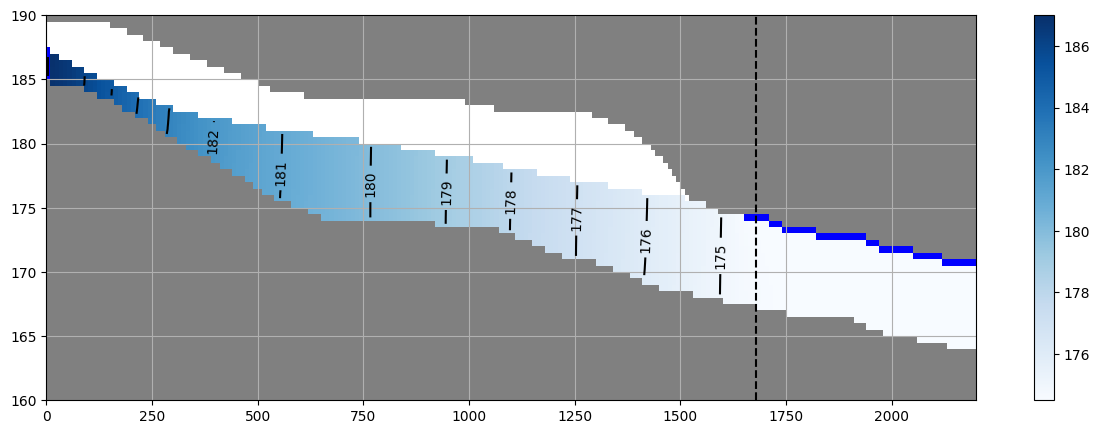

In [123]:
fig = plt.figure(figsize=(15, 5))
xsect = flopy.plot.PlotCrossSection(model=model, line={"Column": 0})

hds = flopy.utils.binaryfile.HeadFile(model_ws + '/example_model.hds')
head_data = hds.get_data(kstpkper=(0, 2)) # (time step, stress period)

ibd = model.bas6.ibound.array
masked_head_data = np.ma.masked_where(ibd== 0, head_data)

cs = xsect.plot_array(masked_head_data, cmap="Blues")
plt.colorbar(cs)


contour_levels = np.arange(164, 188, 1)
contour_set = xsect.contour_array(masked_head_data, levels=contour_levels, colors="black")
plt.clabel(contour_set, inline=True, fontsize=10, fmt="%1.0f")
plt.grid()

ibd = xsect.plot_ibound(color_noflow='grey')
ibd.set_facecolor("red")  # set the color of the masked cells to grey

plt.axvline(x=1680, color='black', linestyle='--')

#plt.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)

plt.show()

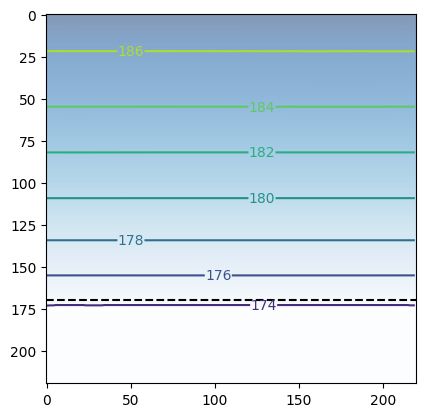

In [39]:


budobj = bf.HeadFile(model_ws + '/example_model.hds')
times = budobj.get_times()
head = budobj.get_data(totim=times[1])
head[head<0]=np.nan

topview = head[0].copy()
for n in range(head.shape[0]):
    layer = head[n]
    topview[np.isnan(topview)] = layer[np.isnan(topview)]

# add contour to the plot
fig, ax = plt.subplots()
c = ax.contour(topview)
ax.clabel(c, inline=True, fontsize=10)
plt.imshow(topview,cmap='Blues',alpha=0.5)
plt.axhline(y=170,c='k',linestyle='dashed')
plt.show()

In [38]:
arr

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

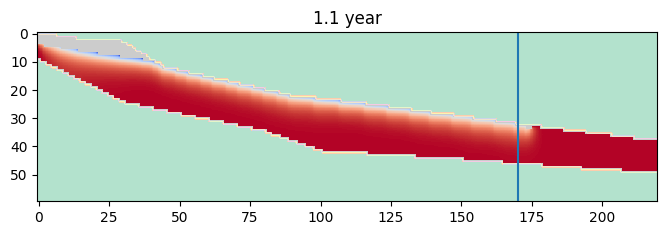

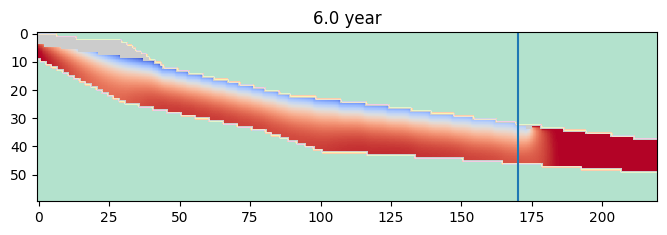

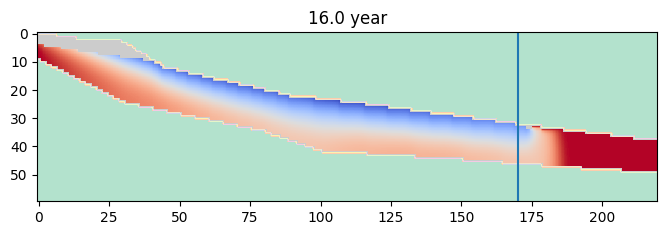

In [44]:
ucnobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)
times = ucnobj.get_times()

for per in [2,12,22]:
    conc = ucnobj.get_data(totim=times[per])
    arr = conc[:, :, 25].copy()
    arr[arr==1.e+30] = np.nan


    # Create a 2x1 grid of subplots
    fig,ax1 = plt.subplots(figsize=(8,5))
    #fig.figure()

    # Plot 'topo' in the first subplot
    ax1.imshow(topo, cmap='Pastel2')
    plt.axvline(x=170)
    # Plot 'arr' in the second subplot
    im = ax1.imshow(arr,cmap='coolwarm')
    plt.title('{:.1f} year'.format(times[per]/365))
    plt.show()


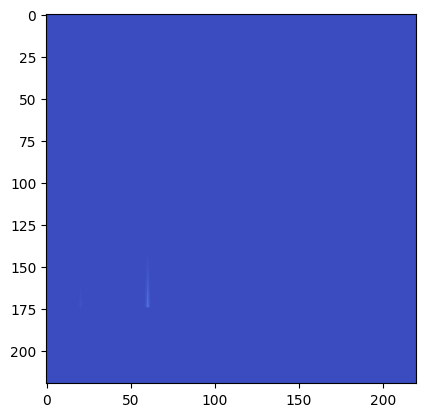

In [50]:
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)
times = budobj.get_times()
conc = budobj.get_data(totim=times[30])
conc[conc==1.e+30]=np.nan


topview = conc[0].copy()
for n in range(conc.shape[0]):
    #print(n)
    layer = conc[n]
    topview[np.isnan(topview)] = layer[np.isnan(topview)]


plt.imshow(topview,cmap='coolwarm',vmin=0,vmax=500)

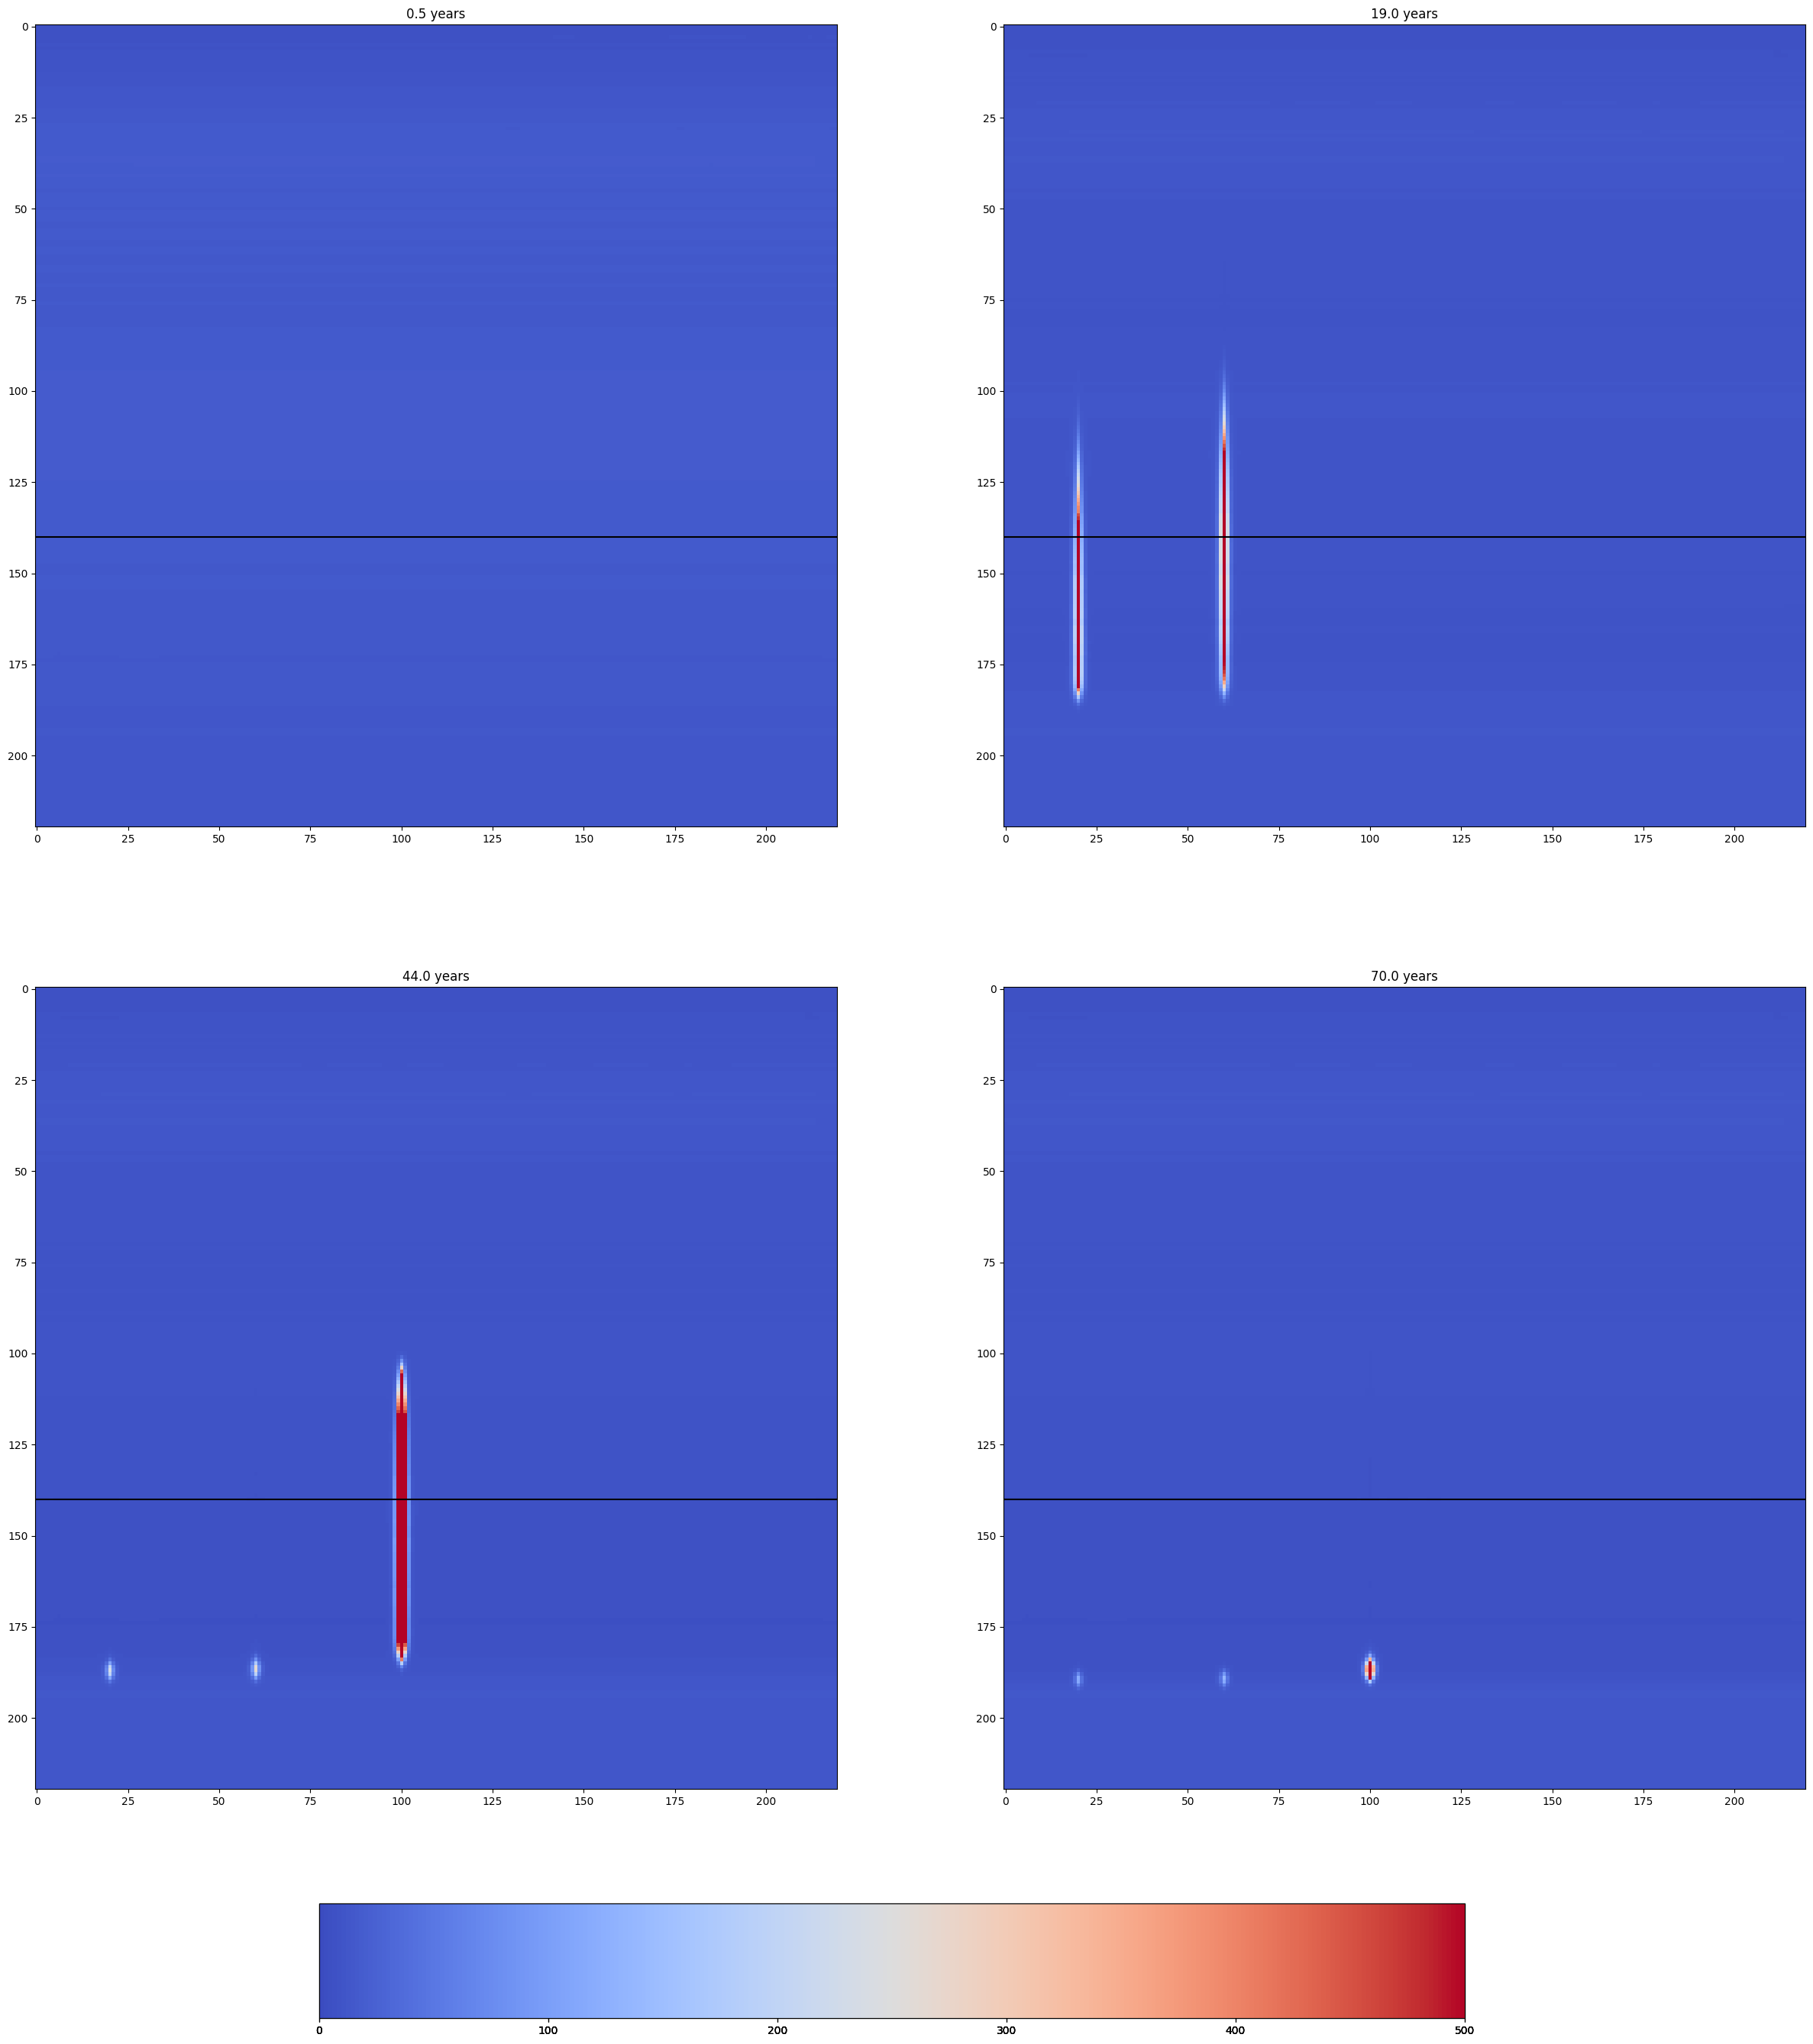

In [46]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(2, 2)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,4)]

# Loop over the selected time indices
for n in range(4):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=140, c='k')

# Set the size of the figure
fig.set_size_inches(30, 30)

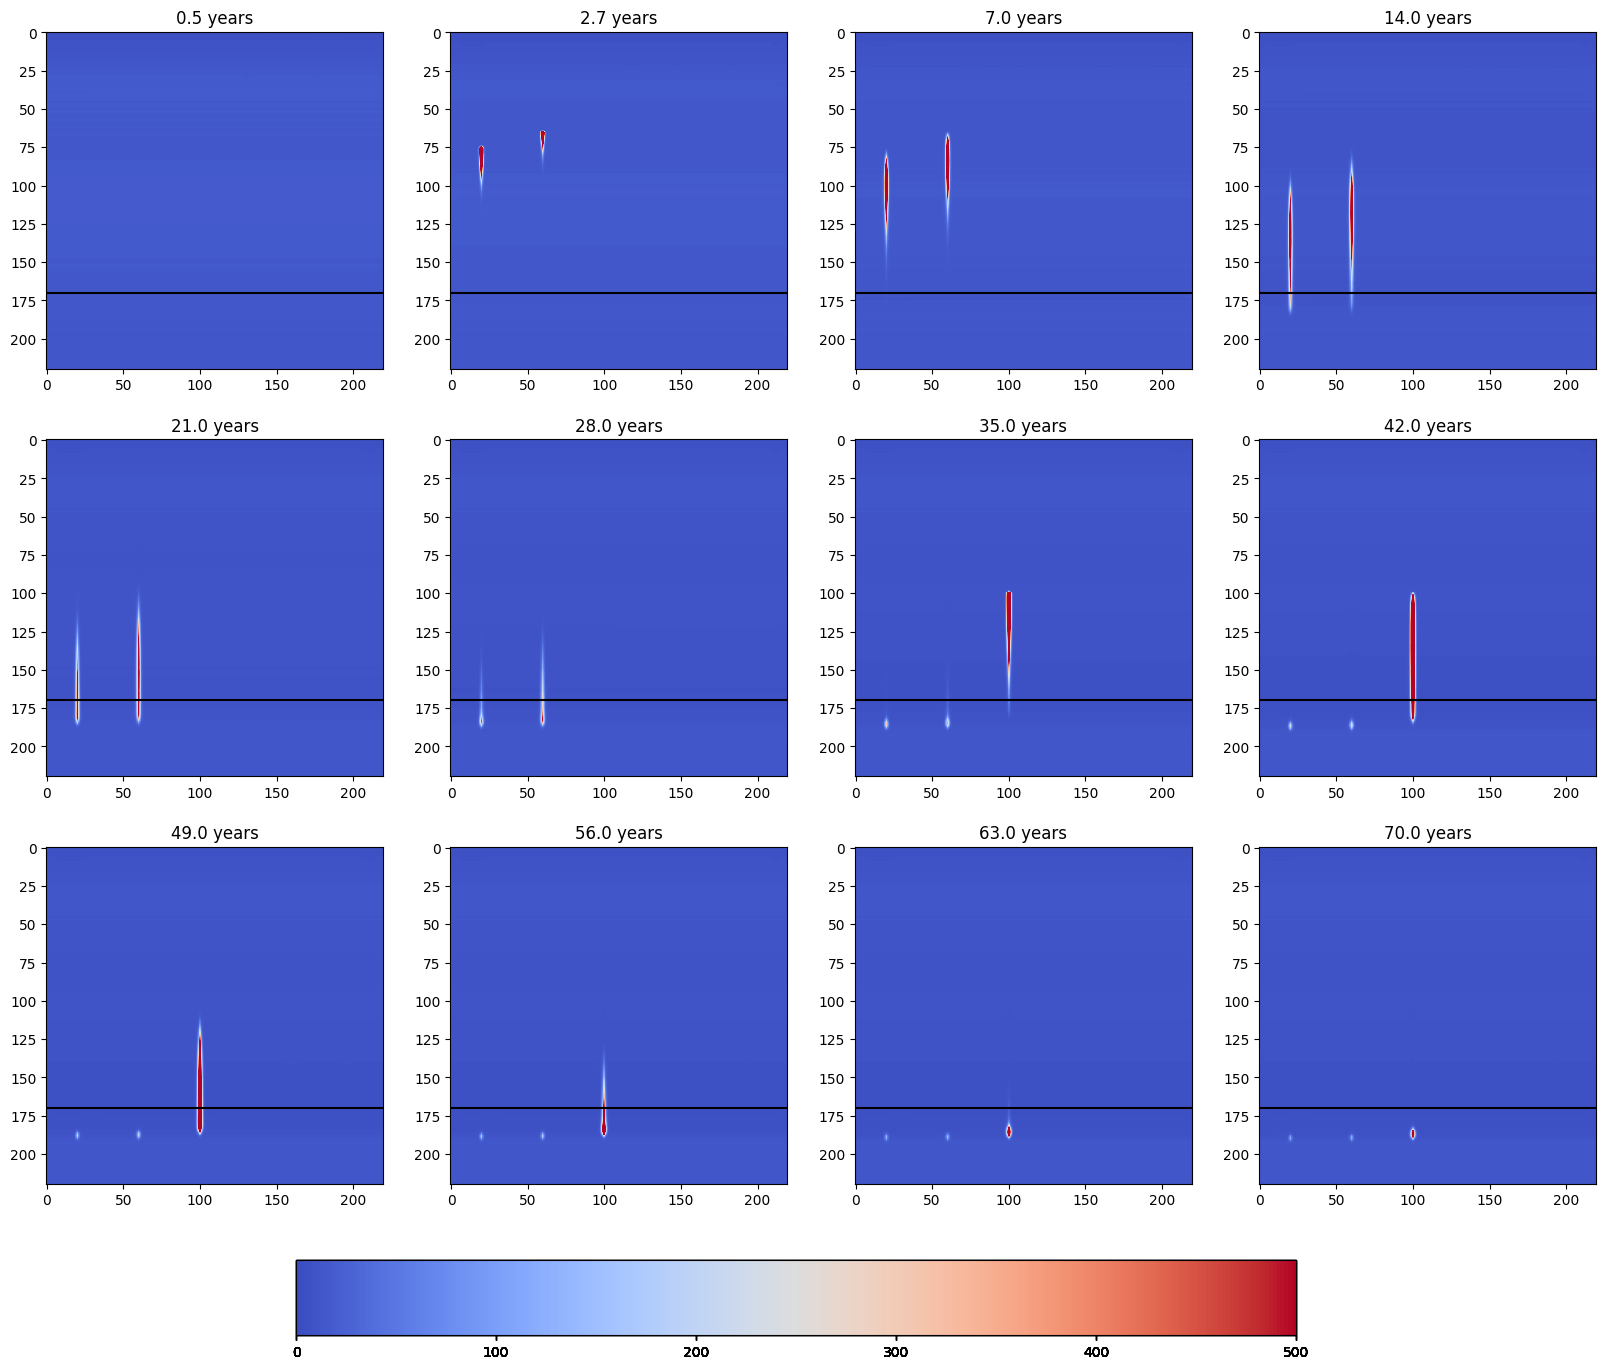

In [47]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(3, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,12)]

# Loop over the selected time indices
for n in range(12):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=170, c='k')

# Set the size of the figure
fig.set_size_inches(20, 15)

In [ ]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(2, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,8)]

# Loop over the selected time indices
for n in range(8):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=140, c='k')

# Set the size of the figure
fig.set_size_inches(20, 8)